# 소비자의 지리적 분포 및 특성 분석

## 데이터 소개

This dataset contains information about used cars.


This data can be used for a lot of purposes such as price prediction to exemplify the use of linear regression in Machine Learning.

이 데이터셋은 중고차에 대한 정보를 포함하고 있습니다.

이 데이터는 머신러닝에서 선형 회귀의 활용을 보여주기 위해 가격 예측과 같은 다양한 목적으로 사용할 수 있습니다.

## 라이브러리 import

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## 데이터 불러오기

In [24]:
file_path_csv = './CAR DETAILS FROM CAR DEKHO.csv'
data = pd.read_csv(file_path_csv)

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


## 각 피쳐 설명

name: 차량 이름

year: 제조 연도

selling_price: 판매 가격

km_driven: 주행 거리 (km)

fuel: 연료 종류 (예: Petrol, Diesel)

seller_type: 판매자 유형 (예: Individual)

transmission: 변속기 유형 (Manual/Automatic)

owner: 소유자 정보 (예: First Owner)

## shape 확인

In [30]:
data.shape

(4340, 8)

데이터 4340개, feture 8개

## 결측치 확인

In [29]:
missing_values = data.isnull().sum()

missing_values

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

결측치 없음

## 데이터 구조 확인

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


### 데이터 타입 요약

| 데이터 타입    | 열 이름                                    |
|----------------|------------------------------------------|
| **숫자형**     | `year`, `selling_price`, `km_driven`     |
| **범주형**     | `name`, `fuel`, `seller_type`, `transmission`, `owner` |


In [27]:
data.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


## 이상치 분석

In [33]:
missing_values = data.isnull().sum()

numerical_columns = ['year', 'selling_price', 'km_driven']
outlier_summary = {}

for column in numerical_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    outlier_summary[column] = {
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "outlier_count": len(outliers),
    }

missing_values, outlier_summary

(name             0
 year             0
 selling_price    0
 km_driven        0
 fuel             0
 seller_type      0
 transmission     0
 owner            0
 dtype: int64,
 {'year': {'lower_bound': 2003.5, 'upper_bound': 2023.5, 'outlier_count': 105},
  'selling_price': {'lower_bound': -378125.625,
   'upper_bound': 1186875.375,
   'outlier_count': 271},
  'km_driven': {'lower_bound': -47500.0,
   'upper_bound': 172500.0,
   'outlier_count': 110}})

year:
하한: 2003.5, 상한: 2023.5
이상치 개수: 105 (주로 오래된 차량 또는 미래 연식 표시)

selling_price:
하한: -378,125.63 (비현실적인 값), 상한: 1,186,875.38
이상치 개수: 271 (특히 높은 가격의 차량)

km_driven:
하한: -47,500 (비현실적인 값), 상한: 172,500
이상치 개수: 110 (주로 비정상적으로 높은 주행 거리)

In [34]:
cleaned_data = data.copy()

for column in numerical_columns:
    Q1 = cleaned_data[column].quantile(0.25)
    Q3 = cleaned_data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cleaned_data = cleaned_data[
        (cleaned_data[column] >= lower_bound) & (cleaned_data[column] <= upper_bound)
    ]

original_rows = len(data)
cleaned_rows = len(cleaned_data)

original_rows, cleaned_rows

(4340, 3858)

## 이상치 482개 제거

In [37]:
cleaned_data.shape

(3858, 8)

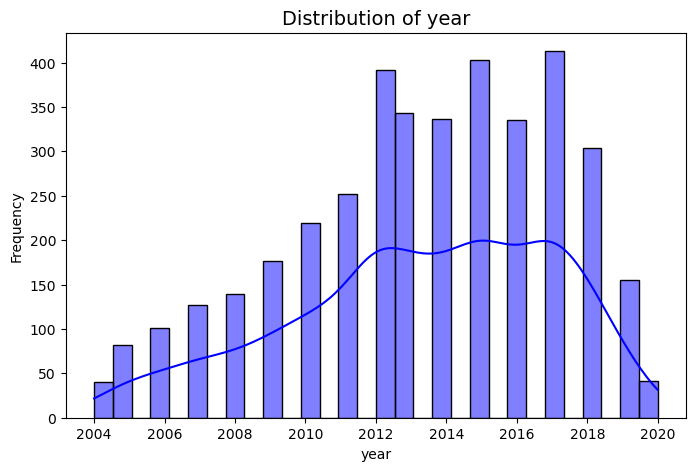

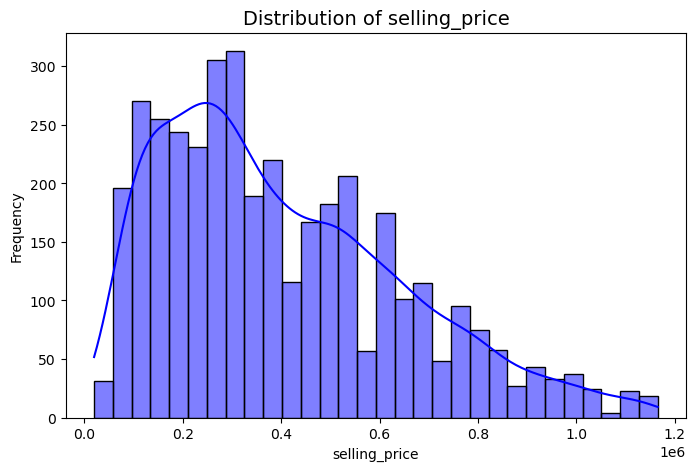

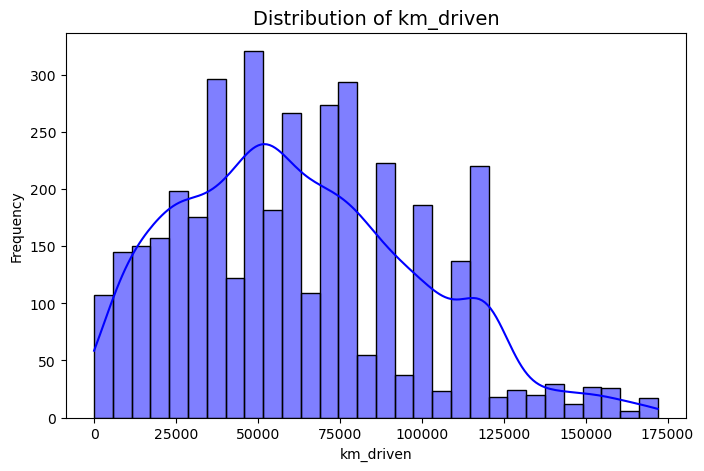

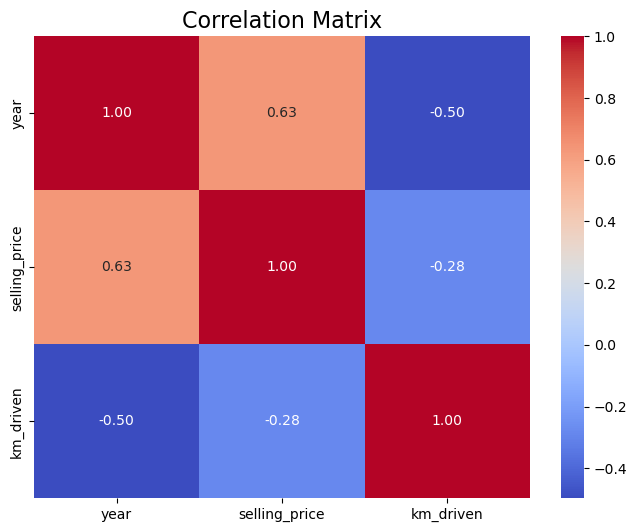

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(cleaned_data[column], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

plt.figure(figsize=(8, 6))
correlation_matrix = cleaned_data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [45]:
cleaned_data['age'] = current_year - cleaned_data['year'] # 현재 년도에서 차의 출고 년도를 빼 차의 나이를 feature에 추가함

categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
encoded_data = pd.get_dummies(cleaned_data, columns=categorical_columns, drop_first=True) # 범주형 변수 인코딩

features = ['age'] + [col for col in encoded_data.columns if col not in ['selling_price', 'year', 'name', 'km_driven']]
X = encoded_data[features]
y = encoded_data['selling_price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

mae, rmse

(119864.24491720073, 164940.63258252156)

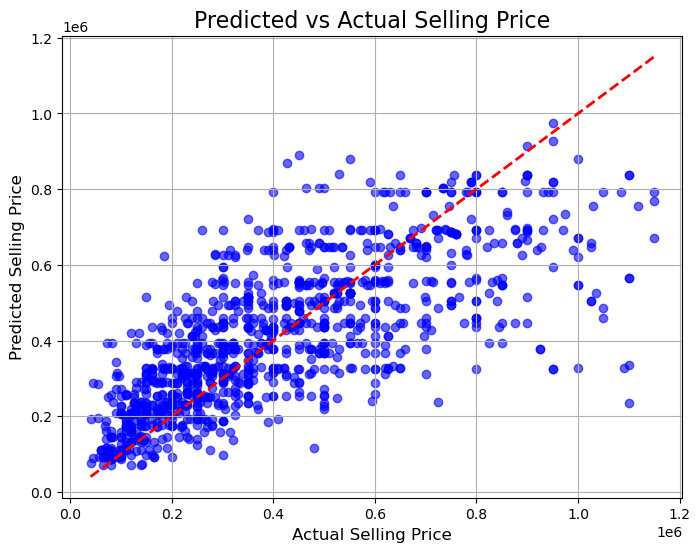

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Selling Price', fontsize=16)
plt.xlabel('Actual Selling Price', fontsize=12)
plt.ylabel('Predicted Selling Price', fontsize=12)
plt.grid(True)
plt.show()

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.3), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"MAE: {mae:.2f}, RMSE: {np.sqrt(loss):.2f}")

y_pred_nn = model.predict(X_test)

Epoch 1/100
34/34 [==============================] - 0s 3ms/step - loss: 223145312256.0000 - mae: 403488.3750 - val_loss: 213520400384.0000 - val_mae: 389898.9062
Epoch 2/100
34/34 [==============================] - 0s 1ms/step - loss: 223119179776.0000 - mae: 403458.3750 - val_loss: 213460090880.0000 - val_mae: 389831.0625
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: 222966808576.0000 - mae: 403296.5000 - val_loss: 213160869888.0000 - val_mae: 389517.5000
Epoch 4/100
34/34 [==============================] - 0s 1ms/step - loss: 222359502848.0000 - mae: 402683.5625 - val_loss: 212145258496.0000 - val_mae: 388496.9375
Epoch 5/100
34/34 [==============================] - 0s 1ms/step - loss: 220632694784.0000 - mae: 400995.8750 - val_loss: 209557864448.0000 - val_mae: 385970.6875
Epoch 6/100
34/34 [==============================] - 0s 1ms/step - loss: 216750489600.0000 - mae: 397255.4375 - val_loss: 204111659008.0000 - val_mae: 380713.2500
Epoch 7/100
34/34 [===

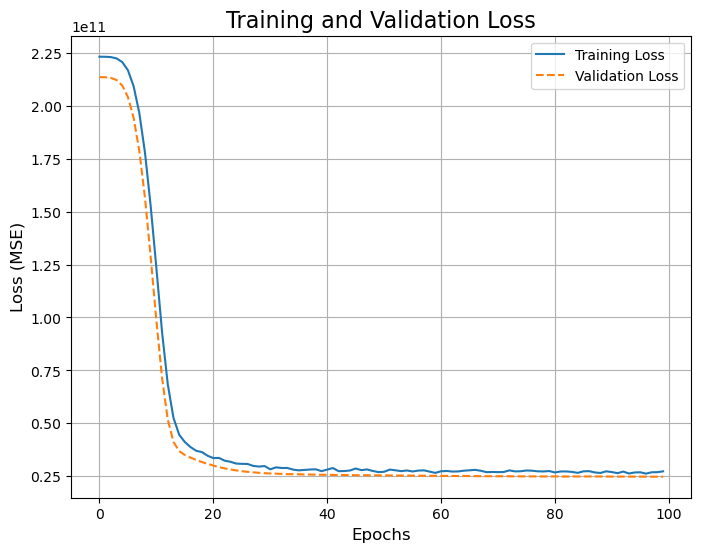

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

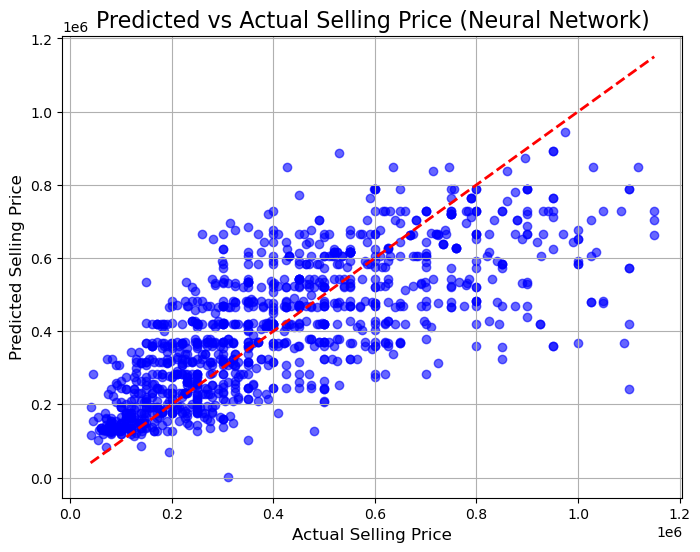

In [58]:
# Predicted vs Actual Selling Price
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Selling Price (Neural Network)', fontsize=16)
plt.xlabel('Actual Selling Price', fontsize=12)
plt.ylabel('Predicted Selling Price', fontsize=12)
plt.grid(True)
plt.show()